In [1]:
# This ensures to use the source code if not installed as Python package
try:
    import rapidAlignerSeismic
except:
    import os, sys
    sys.path.append(os.path.join(os.getcwd(),".."))

This notebooks runs an example of template matching for one three-component station. The CC functions corresponding to each components are stacked to decrease the level of noise and improve the detection level.

In [2]:
import glob

In [3]:
import rapidAlignerSeismic as ras
import cupy as cp
import numpy as np
import pylab as pl

In [4]:
from datetime import datetime
from obspy.core import Stream, read
from obspy import UTCDateTime
from obspy.io.xseed import Parser

In [5]:
#Default values
# -------------------------------------------------------------------------------
#Repository containing data
template_dir = '../data/templates_chile'
wf_dir       = '../data/wf_chile'

#Repository to write results
output_dir = '../data/corr'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

#Station informations. The use of wildcards allows to select several files at once.
network = 'C1'
station = 'MT03'
channel = 'HH?'
jday    = '2018.053'
# -------------------------------------------------------------------------------

In [6]:
#Signal parameters
# -------------------------------------------------------------------------------
# Pass filter corner frequencies [Hz] (Float, Integer)
fmin = 2
fmax = 20
# Decimation flag (Boolean, True or False)
decimate = False

In [7]:
for dailyf in sorted(glob.glob(wf_dir + '/*'+station+'*.'+channel+'.*.'+jday)):
    
    # get info
    dailyNetw = os.path.basename(dailyf).split('.')[0]
    dailyStat = os.path.basename(dailyf).split('.')[1]
    dailyChan = os.path.basename(dailyf).split('.')[3]
    dailyYear = os.path.basename(dailyf).split('.')[5]
    dailyJday = os.path.basename(dailyf).split('.')[6]
    
    for templatef in sorted(glob.glob(template_dir +'/'+ dailyNetw +'.'+ dailyStat +'*.'+ dailyChan +'.*.'+ jday + '*')):
        #print(templatef)

        #Load daily and template and perform a copy on GPU
        dailySig, dailySr, dailyTbeg, dailyTend = ras.util.DailyLoader(dailyf, fmin, fmax, decimate).data   
        dailySig_gpu      = cp.asarray(dailySig)

        #template, template length, template sampling rate
        templateSig, templateLen, templateSr  = ras.util.TemplateLoader(templatef, fmin, fmax, decimate).data 
        templateSig_gpu                       = cp.asarray(templateSig)

        if dailySr != templateSr:
            print('Sampling rate for both template and stream must be the same!')
        
        #Perform template matching
        #Using Rolling mean- and amplitude-adjusted Euclidean Distance using FFT ##TO DO MODIF: on ne calcule que correlation à terme
        dist , corr = ras.ED.zdist(templateSig_gpu, dailySig_gpu, mode="fft")

        #Write results
        # save to binary files
        corr = corr.astype('float32')
        cp.save(output_dir+'/corr.'+dailyNetw+'.'+dailyStat+'.'+dailyChan+'.'+dailyYear+'.'+dailyJday+'.npy', corr)

Stacking station MT03 julian day 2018.053


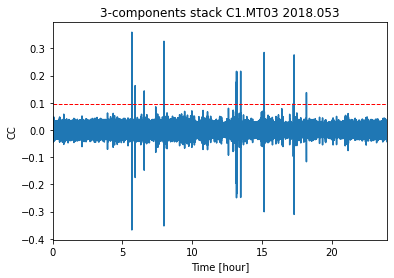

find matches...
cleanup matches...
0 2018-02-22T05:40:59.020000Z 0.36
1 2018-02-22T05:55:12.510000Z 0.16
2 2018-02-22T06:34:05.000000Z 0.14
3 2018-02-22T07:59:05.360000Z 0.33
4 2018-02-22T13:09:21.820000Z 0.18
5 2018-02-22T13:11:07.980000Z 0.22
6 2018-02-22T13:13:27.970000Z 0.21
7 2018-02-22T13:29:03.140000Z 0.22
8 2018-02-22T15:09:58.880000Z 0.28
9 2018-02-22T15:10:24.240000Z 0.26
10 2018-02-22T17:15:30.710000Z 0.10
11 2018-02-22T17:18:56.110000Z 0.28
12 2018-02-22T18:11:52.100000Z 0.14
Plotting clean matches for station MT03


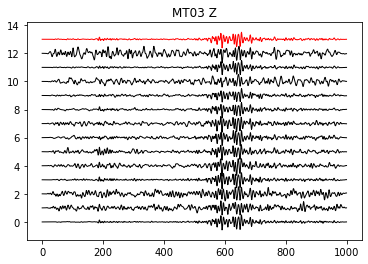

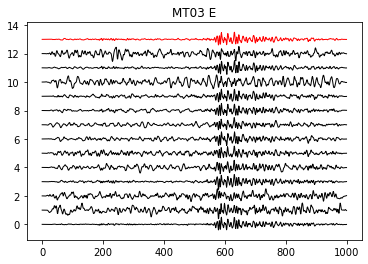

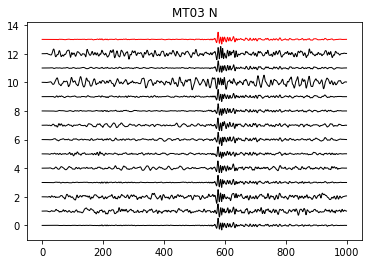

In [8]:
#Plot and show detections
ras.util.plot_match_multi_comp(network, station, channel, jday, templateLen, templateSr, output_dir, wf_dir)

The last figures should display the corresponding detections (black) and the stacked strace (red) with normalized amplitudes, this time for the three components. By stacking the CC functions, we quite reduce the level of noise allowing a lower detection treshold.